In [1]:
%matplotlib inline
import os
import sys
import gc
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pygame
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.model_wrapper import ModelWrapper
from src.learning.training.collector import Collector
from src.learning.training.training_file_reader import TrainingFileReader
from src.utilities.transformer import Transformer
from notebooks.notebook_commons import read_stored_data_with_labels, read_stored_data_with_shifted_labels, create_memorized_dataset

window_width = 500
window_height = 200

black = (0, 0, 0)
white = (255, 255, 255)
red = (255, 0, 0)
green = (0, 153, 0)
blue = (0, 128, 255)

pygame.init()
font = pygame.font.SysFont('Roboto', 20)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def plot_stuff(title, plot_elems, figsize=(18, 6)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Count')
    
    for plot_elem in plot_elems:
        plt.plot(plot_elem['data'], label=plot_elem['label'], alpha=plot_elem['alpha'])

    plt.grid(axis='y')
    plt.legend(loc='best')
    plt.show()
        
def get_mem_dataset_with_full_video(filename, length, interval):
    mem_frames_np, mem_telemetry_np, mem_diffs_np = create_memorized_dataset(*read_stored_data_with_labels(reader, transformer, filename, collector.steering_columns(), collector.diff_steering_columns()), length, interval)
    view_frames_np = reader.read_video(filename + '.avi')[((length - 1) * interval):]
    
    assert view_frames_np.shape[0] == mem_frames_np.shape[0], "Frames length mismatch!"
    assert mem_frames_np.shape[0] == mem_telemetry_np.shape[0] == mem_diffs_np.shape[0], "Mem lengths differ!"
    return mem_frames_np, mem_telemetry_np, mem_diffs_np, view_frames_np

def get_shifted_mem_dataset_with_full_video(filename, length, interval):
    mem_frames_np, mem_telemetry_np, mem_diffs_np = create_memorized_dataset(*read_stored_data_with_shifted_labels(reader, transformer.cut_wide_and_normalize_video_shifted, filename, collector.numeric_columns(), collector.steering_column()), length, interval)
    view_frames_np = reader.read_video(filename + '.avi')[((length - 1) * interval):-1]
    
    assert view_frames_np.shape[0] == mem_frames_np.shape[0], "Frames length mismatch!"
    assert mem_frames_np.shape[0] == mem_telemetry_np.shape[0] == mem_diffs_np.shape[0], "Mem lengths differ!"
    return mem_frames_np, mem_telemetry_np, mem_diffs_np, view_frames_np

def validate_partial(memory, i):
    memory_string = 'n{}_m{}'.format(*memory)
    path = '../../training/' + memory_string + '/'

    mem_frame = np.load(path + GenFiles.frame.format(memory_string, i)) * 255
    return mem_frame.astype(np.uint8)[:,:,:3]

def steering_texts(predicted_steering, true_steer):
    pred_steer_str = "S: {0:.4f}".format(predicted_steering)
    if predicted_steering >= 0.0:
        pred_steer_text = font.render(pred_steer_str, True, green)
    else:
        pred_steer_text = font.render(pred_steer_str, True, blue)

    true_steer_str = "true S: {0:.4f}".format(true_steer)
    if true_steer >= 0.0:
        true_steer_text = font.render(true_steer_str, True, green)
    else:
        true_steer_text = font.render(true_steer_str, True, blue)

    return pred_steer_text, true_steer_text

def throttle_texts(predicted_throttle, true_throttle):
    pred_throttle_str = "T: {0:.4f}".format(predicted_throttle)
    pred_throttle_text = font.render(pred_throttle_str, True, green)

    true_throttle_str = "true T: {0:.4f}".format(true_throttle)
    true_throttle_text = font.render(true_throttle_str, True, green)
    
    return pred_throttle_text, true_throttle_text

def gear_texts(predicted_gear, true_gear):
    pred_gear_str = "G: {}".format(predicted_gear)
    pred_gear_text = font.render(pred_gear_str, True, green)

    true_gear_str = "true G: {}".format(true_gear)
    true_gear_text = font.render(true_gear_str, True, green)
    
    return pred_gear_text, true_gear_text

In [3]:
config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/validation_laps/')
collector = Collector()

validation_laps = ['2020_02_28_lap_15']
validation_lap = validation_laps[0]
memory_variants = [(1, 1), (4, 1), (4, 4), (8, 1), (8, 4), (12, 1)]

memory = memory_variants[0]
model_num = 4

transformer = Transformer(config, memory_tuple=memory)

mem_frames, mem_telems, mem_diffs, display_frames = get_shifted_mem_dataset_with_full_video(validation_lap, *memory)
print(mem_frames.shape)
print(mem_telems.shape)

(5018, 50, 180, 3)
(5018, 4)


In [4]:
multi = ModelWrapper(config, output_shape=2, memory_tuple=memory, model_num=model_num)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50, 180, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 25, 90, 24)   1824        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 13, 45, 36)   21636       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 23, 48)    43248       conv2d_6[0][0]                   
____________________________________________________________________________________________

In [5]:
pred_gear_list = []
true_gear_list = []
pred_steer_list = []
true_steer_list = []
pred_throttle_list = []
true_throttle_list = []

pygame.display.init()
pygame.display.set_caption("Prediction viewer")
screen = pygame.display.set_mode((window_width, window_height))

try:
    pred_smoothing = []
    for i in range(0, display_frames.shape[0]):
        frame = display_frames[i]
        screen.fill(black)
        
        converted_telem = mem_telems[i][np.newaxis, :]
        converted_frame = mem_frames[i][np.newaxis, :]
        
        # gear, steering, throttle, braking
        prediction = multi.predict(mem_frames[i], mem_telems[i]).to_dict()
        predicted_gear = prediction['d_gear']
        predicted_steering = prediction['d_steering']
        predicted_throttle = prediction['d_throttle']
        
        # TODO get columns when N > 1
        true_gear = mem_telems[i, 0]
        true_steer = mem_telems[i, 1]
        true_throttle = mem_telems[i, 2]
        
        pred_gear_text, true_gear_text = gear_texts(predicted_gear, true_gear)
        pred_steer_text, true_steer_text = steering_texts(predicted_steering, true_steer)
        pred_throttle_text, true_throttle_text = throttle_texts(predicted_throttle, true_throttle)
        
        pred_gear_list.append(predicted_gear)
        true_gear_list.append(true_gear)
        pred_steer_list.append(predicted_steering)
        true_steer_list.append(true_steer)
        pred_throttle_list.append(predicted_throttle)
        true_throttle_list.append(true_throttle)
        
        #frame = mem_frames[i][:,:,:3]
        #frame = validate_partial(memory, i)
        frame = np.rot90(frame)
        surface = pygame.surfarray.make_surface(frame)
        
        x = (window_width - frame.shape[0]) // 2
        y = 0
        
        time.sleep(0.05)
        screen.blit(pred_gear_text, (50, window_height - 75))
        screen.blit(true_gear_text, (50, window_height - 45))
        screen.blit(pred_steer_text, (150, window_height - 75))
        screen.blit(true_steer_text, (150, window_height - 45))
        screen.blit(pred_throttle_text, (250, window_height - 75))
        screen.blit(true_throttle_text, (250, window_height - 45))
        screen.blit(surface, (x, y))
        pygame.display.update()

        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    sys.exit(0)
    pygame.display.quit()
except (KeyboardInterrupt, SystemExit, Exception) as ex:
    print(ex)
    pygame.display.quit()

0


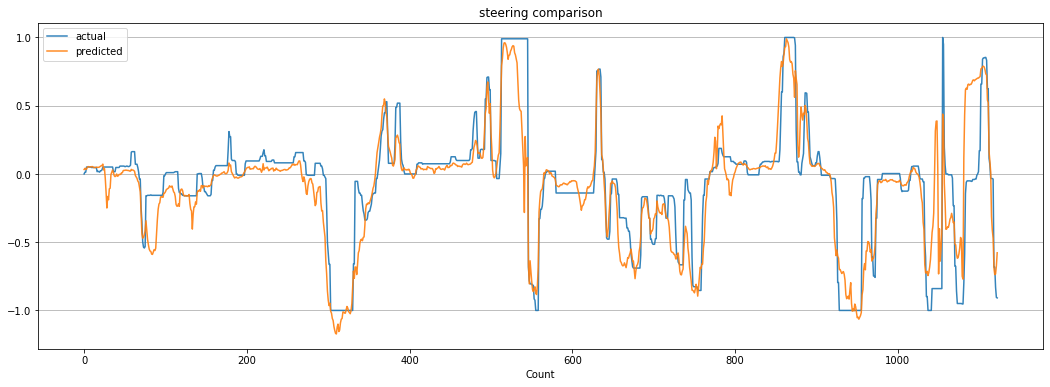

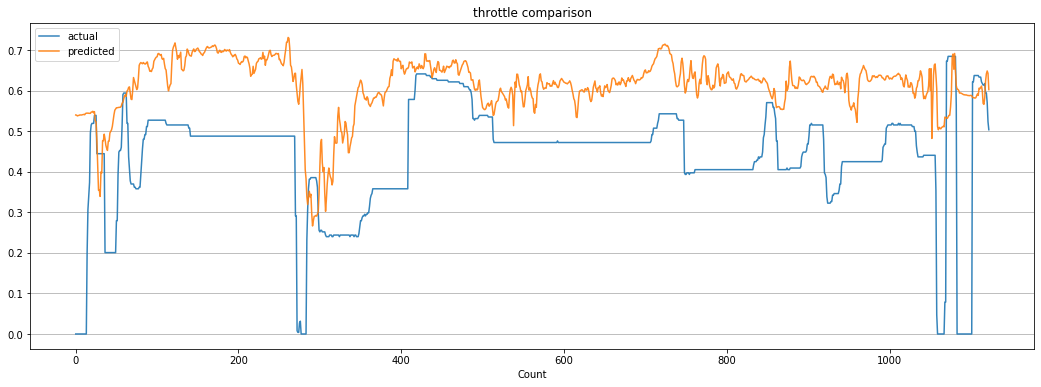

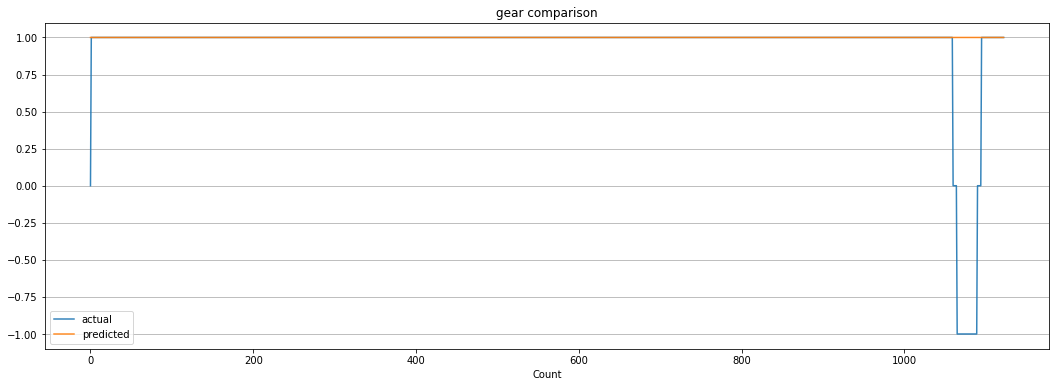

In [6]:
plotto = []
plotto.append({'data': true_steer_list, 'label': 'actual', 'alpha': 0.9})
plotto.append({'data': pred_steer_list, 'label': 'predicted', 'alpha': 0.9})

plot_stuff('steering comparison', plotto)

plotto_2 = []
plotto_2.append({'data': true_throttle_list, 'label': 'actual', 'alpha': 0.9})
plotto_2.append({'data': pred_throttle_list, 'label': 'predicted', 'alpha': 0.9})

plot_stuff('throttle comparison', plotto_2)

plotto_3 = []
plotto_3.append({'data': true_gear_list, 'label': 'actual', 'alpha': 0.9})
plotto_3.append({'data': pred_gear_list, 'label': 'predicted', 'alpha': 0.9})

plot_stuff('gear comparison', plotto_3)

In [ ]:
df = reader.read_specific_telemetry_columns('2020_02_27_i1.csv', ['c', 'conn_time', 'p_start', 'p_end'])
df.drop(df.tail(1).index,inplace=True)
data = df.to_numpy()

plot_data = []
plot_data.append({'data': data[10:, 1]- data[10:, 0], 'label': 'conn diff millis', 'alpha': 0.7})
plot_data.append({'data': data[10:, 3]- data[10:, 2], 'label': 'p diff millis', 'alpha': 0.7})
plot_stuff('connection and predict time elapsed', plot_data)

plot_data = []
plot_data.append({'data': data[:, 2]- data[:, 1], 'label': 'zmq diff millis', 'alpha': 0.7})
plot_stuff('time diff between connection and predict', plot_data)

t = np.mean(data[1:, 3]- data[1:, 2])
print(t)
print('FPS: {}'.format(1/(t / 1000)))

In [ ]:
a = {'a': 2}
b = a
b['b'] = 3

print(a)
print(b)

from PIL import Image

frame = mem_frames[2250][:,:,:3]
Image.fromarray((frame * 255).astype(np.uint8)).show()

from datetime import datetime
print(datetime.now().timestamp())